# INTRO

## (General steps) Road to pipeline
* Import neccessary libraries
    * define useful functions - (no missing values)
    * read in data
<br><br>
* filter sector-wise data
* preprocess the filtered data
    * plot sector-wise visualization
    * check for missing data
    * clean outliers
    * sector-wise groupings by volume (low/mid/high)
<br><br>
* modelling
    * hyperparameters/tunings
    * cross validation
    * feature engineering
    * prediction backtesting
<br><br>
* forecasting
    * time series pipeline

# IMPORT LIBRARIES & READ DATA

## google drive mount to colab

In [1]:
# # connect to gdrive first
# from google.colab import drive
# drive.mount('/content/gdrive')

## importing

In [2]:
import numpy as np
import pandas as pd
import math
import random
import itertools
import time

# visualization
import seaborn as sns
sns.set_style('darkgrid')

# date libraries
import datetime
import holidays
from datetime import date

# matplotlib libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.dates as mdates

# scipy library
from scipy import stats
from scipy.stats import norm

# sklearn library
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# prophet library
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation


/home/lordmax/.virtualenvs/jupyterworld/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## defining useful functions

In [3]:
# missing data
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

# mean absolute percentage error function
def mape(actual, pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function

    input: list/series for actual values and predicted values
    output: mape value
    '''

    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## read data

In [4]:
datapath = 'relevant_stock_market_data2.csv'
# datapath = '/content/gdrive/MyDrive/Molten Trust Limited/stock market time series data/relevant_stock_market_data2.csv'

In [5]:
tsdata = pd.read_csv(datapath, parse_dates=['DATE'], index_col='DATE')

In [6]:
min(tsdata.index), max(tsdata.index)

(Timestamp('2003-01-02 00:00:00'), Timestamp('2023-02-28 00:00:00'))

In [7]:
tsdata['SECTOR'].unique()

array(['SERVICES', 'FINANCIAL SERVICES', 'NATURAL RESOURCES',
       'CONSTRUCTION/REAL ESTATE', 'OIL AND GAS', 'INDUSTRIAL GOODS',
       'CONSUMER GOODS', 'CONGLOMERATES', 'HEALTHCARE', 'AGRICULTURE',
       'ICT', 'UTILITIES'], dtype=object)

# FILTER/RESTRUCTURE

In [8]:
# filtering for agriculture stocks
filtered_stock_data = tsdata[tsdata['SECTOR'] == 'CONSTRUCTION/REAL ESTATE']

In [9]:
del filtered_stock_data['SECTOR']

In [10]:
filtered_stock_data.head()

,SYMBOL,CLOSEPRICE
DATE,,
2003-01-02,ARBICO,1.25
2003-01-03,ARBICO,1.25
2003-01-06,ARBICO,1.25
2003-01-07,ARBICO,1.25
2003-01-08,ARBICO,1.25


In [11]:
filtered_stock_data.SYMBOL.unique()


array(['ARBICO', 'JBERGER', 'SMURFIT', 'UPDC', 'SFSREIT', 'UHOMREIT',
       'UPDCREIT', 'RONCHESS'], dtype=object)

In [12]:
# pivoting the Dataframe to the number of unique symbols
pivoted_tsdata = filtered_stock_data.pivot(columns='SYMBOL', values='CLOSEPRICE')
final_tsdata = pivoted_tsdata.rename(columns={'ARBICO': 'ARBICO', 'JBERGER': 'JBERGER', 'SMURFIT': 'SMURFIT',
                                              'UPDC': 'UPDC', 'SFSREIT': 'SFSREIT', 'UHOMREIT': 'UHOMREIT', 'UPDCREIT': 'UPDCREIT', 'RONCHESS': 'RONCHESS'})


In [13]:
# Resample the data with daily frequency by interpolation
constructionrs_tsdata = final_tsdata.resample('D').interpolate(method='linear')

In [14]:
constructionrs_tsdata.fillna(0, inplace=True)

# PREPROCESSING

## visualization

In [15]:
constructionrs_tsdata.head()

SYMBOL,ARBICO,JBERGER,RONCHESS,SFSREIT,SMURFIT,UHOMREIT,UPDC,UPDCREIT
DATE,,,,,,,,
2003-01-02,1.25,20.0,0.0,0.0,1.45,0.0,3.850000,0.0
2003-01-03,1.25,20.0,0.0,0.0,1.45,0.0,4.000000,0.0
2003-01-04,1.25,20.0,0.0,0.0,1.45,0.0,3.986667,0.0
2003-01-05,1.25,20.0,0.0,0.0,1.45,0.0,3.973333,0.0
2003-01-06,1.25,20.0,0.0,0.0,1.45,0.0,3.960000,0.0


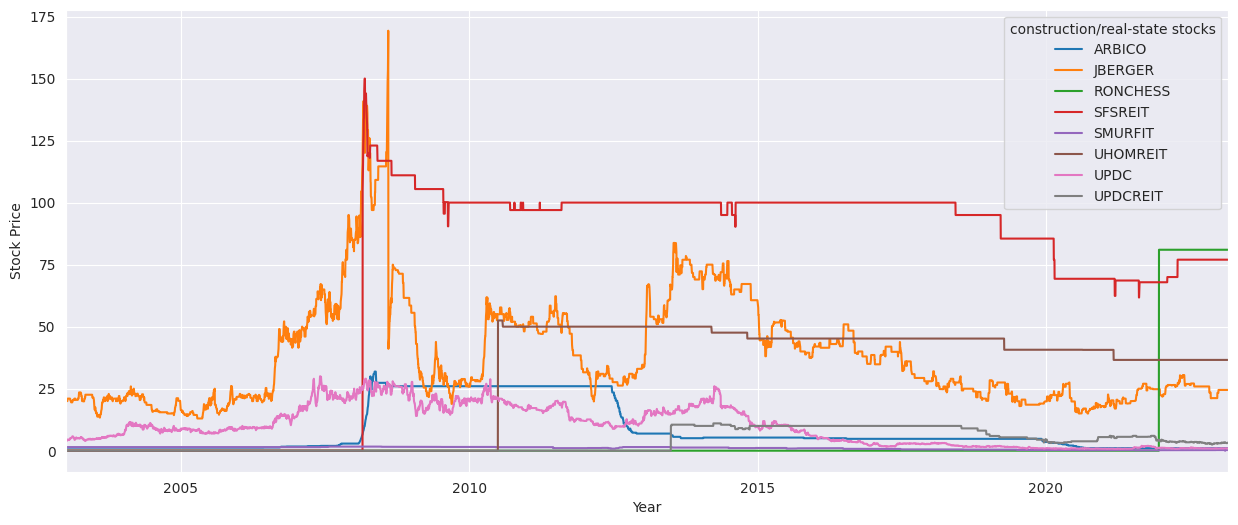

In [17]:
# Plotting
constructionrs_tsdata.plot(figsize=(15, 6))
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend(title='construction/real-state stocks', loc='upper right')
plt.show()

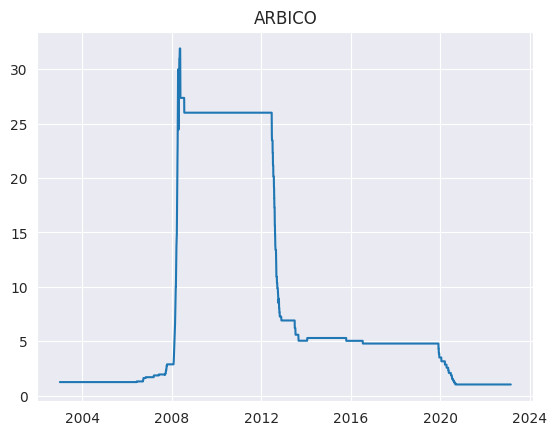

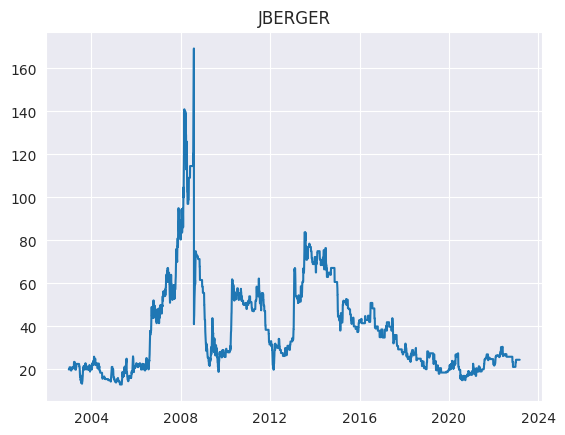

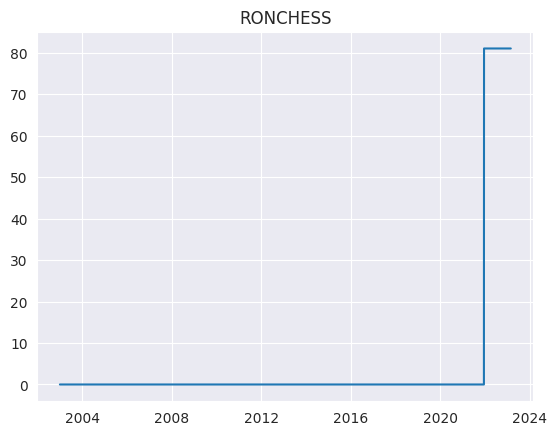

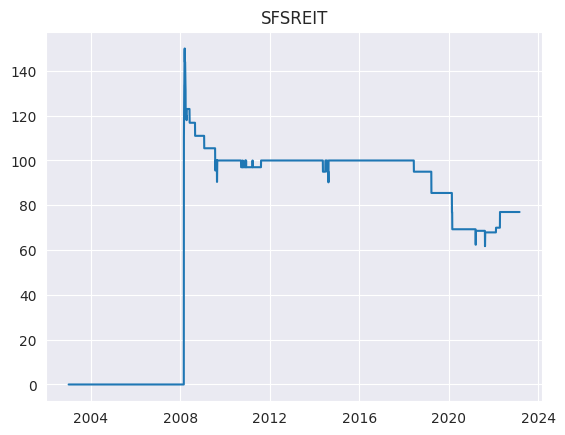

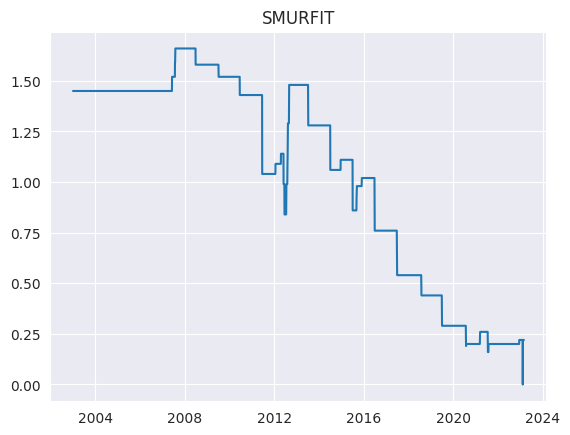

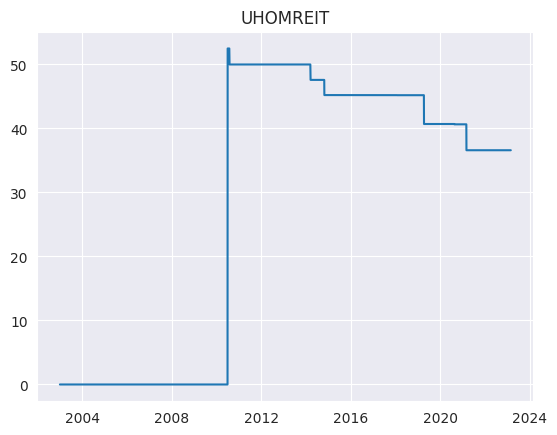

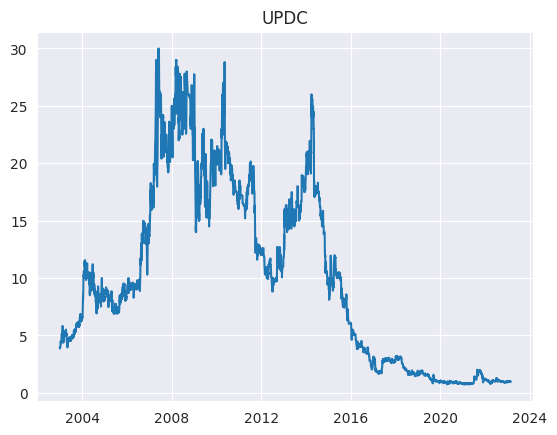

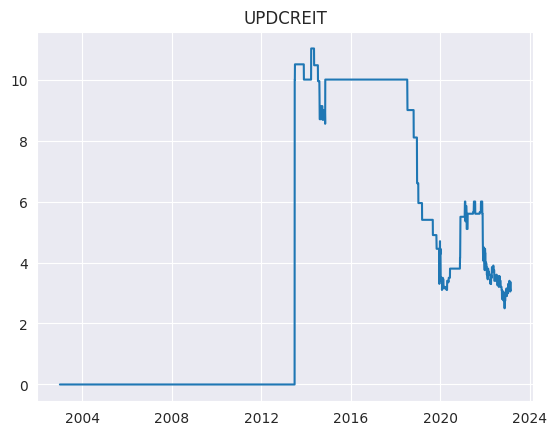

In [18]:
for column in constructionrs_tsdata.columns:
    plt.plot(constructionrs_tsdata[column])
    plt.title(column)
    plt.show()

## cleaning

In [19]:
missing_data(constructionrs_tsdata)

,Total,Percent,Types
SYMBOL,,,
ARBICO,0,0.0,float64
JBERGER,0,0.0,float64
RONCHESS,0,0.0,float64
SFSREIT,0,0.0,float64
SMURFIT,0,0.0,float64
UHOMREIT,0,0.0,float64
UPDC,0,0.0,float64
UPDCREIT,0,0.0,float64


## outliers

<b>`Data Cleaning Requirements`</b>
* remove outliers (automated by calculating and removing <b>`z-score`</b>, while Prophet helps impute those values). This will remove the outliers near 0 for all categories.

In [20]:
# getting percentage of rows for each sector that is at 0

(constructionrs_tsdata == 0).astype(int).sum(axis=0)/len(constructionrs_tsdata.sum(axis=0))

SYMBOL
ARBICO        0.000
JBERGER       0.000
RONCHESS    865.500
SFSREIT     235.125
SMURFIT       0.125
UHOMREIT    342.250
UPDC          0.000
UPDCREIT    479.125
dtype: float64

In [32]:
# breaking out each construction/real-estate stocks into it's own dataframe
prediction_df_constructionrs_list = []

# cleaning up dataframe using z-score to remove outliers that heavily bias the model
for column in constructionrs_tsdata.columns:
    df_constructionrs_clean = constructionrs_tsdata[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_constructionrs_clean[column]))
    outlier_index = np.where(z > 4)[0] # As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)a
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_constructionrs_clean.drop(index=outlier_index,inplace=True)
    df_constructionrs_clean.set_index('DATE', inplace=True)
    prediction_df_constructionrs_list.append(df_constructionrs_clean)

Dropping 0 rows for following category: ARBICO
Dropping 43 rows for following category: JBERGER
Dropping 0 rows for following category: RONCHESS
Dropping 0 rows for following category: SFSREIT
Dropping 0 rows for following category: SMURFIT
Dropping 0 rows for following category: UHOMREIT
Dropping 0 rows for following category: UPDC
Dropping 0 rows for following category: UPDCREIT


In [33]:
prediction_df_constructionrs_list

[SYMBOL      ARBICO
 DATE              
 2003-01-02    1.25
 2003-01-03    1.25
 2003-01-04    1.25
 2003-01-05    1.25
 2003-01-06    1.25
 ...            ...
 2023-02-24    1.03
 2023-02-25    1.03
 2023-02-26    1.03
 2023-02-27    1.03
 2023-02-28    1.03
 
 [7363 rows x 1 columns],
 SYMBOL      JBERGER
 DATE               
 2003-01-02     20.0
 2003-01-03     20.0
 2003-01-04     20.0
 2003-01-05     20.0
 2003-01-06     20.0
 ...             ...
 2023-02-24     24.5
 2023-02-25     24.5
 2023-02-26     24.5
 2023-02-27     24.5
 2023-02-28     24.5
 
 [7320 rows x 1 columns],
 SYMBOL      RONCHESS
 DATE                
 2003-01-02       0.0
 2003-01-03       0.0
 2003-01-04       0.0
 2003-01-05       0.0
 2003-01-06       0.0
 ...              ...
 2023-02-24      81.0
 2023-02-25      81.0
 2023-02-26      81.0
 2023-02-27      81.0
 2023-02-28      81.0
 
 [7363 rows x 1 columns],
 SYMBOL      SFSREIT
 DATE               
 2003-01-02      0.0
 2003-01-03      0.0
 2003-01-04  

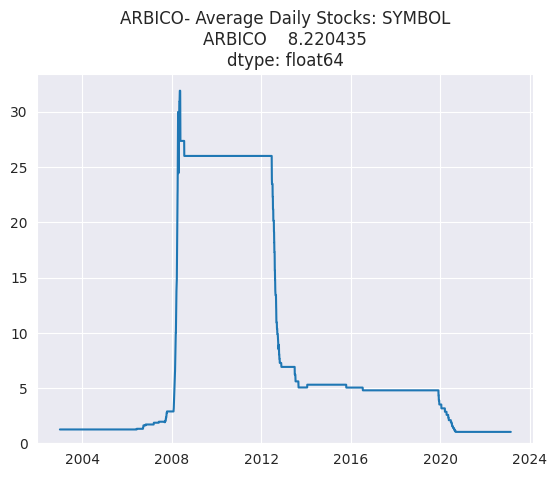

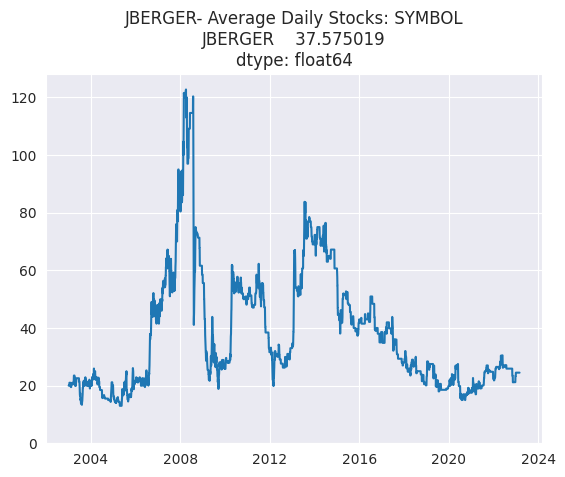

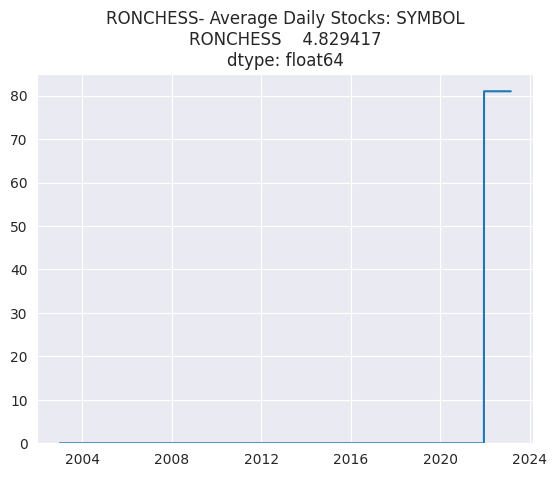

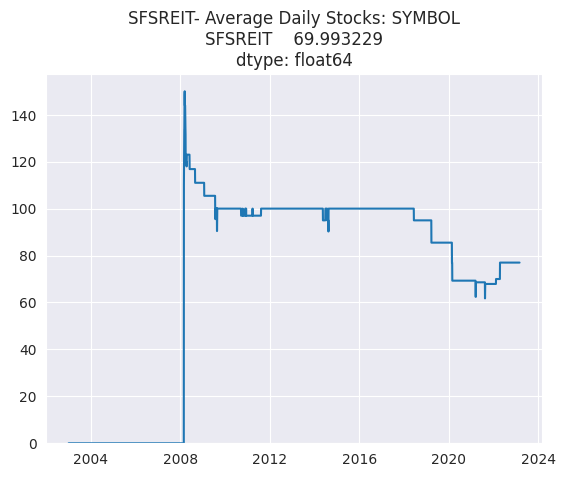

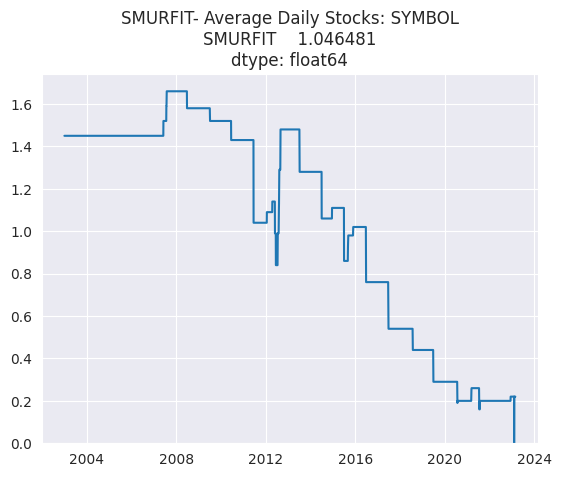

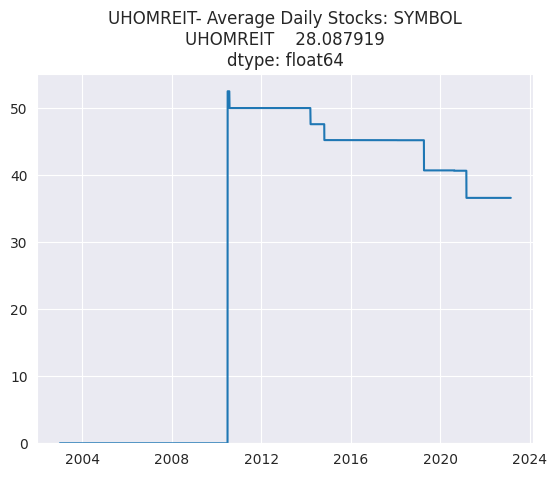

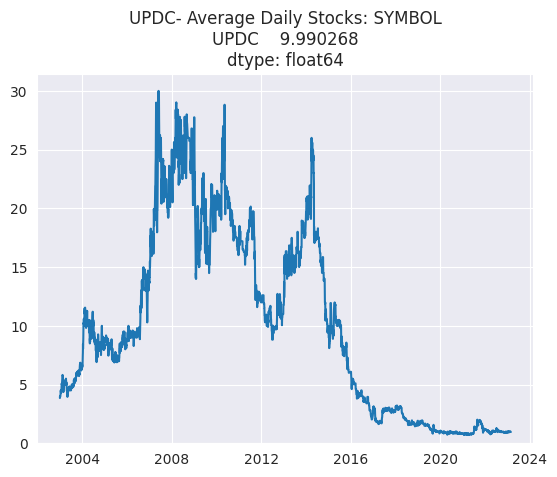

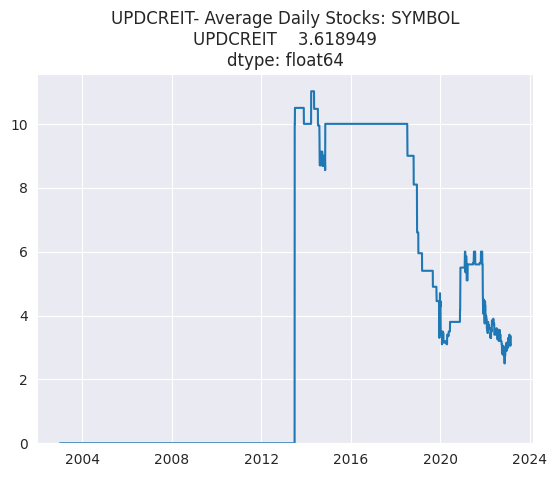

In [34]:
for i in range(len(prediction_df_constructionrs_list)):
    plt.plot(prediction_df_constructionrs_list[i])
    plt.title(prediction_df_constructionrs_list[i].columns[0]+'- Average Daily Stocks: '+str(prediction_df_constructionrs_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

## sector-wise groupings (low/mid/high)

In [35]:
average_closeprices = constructionrs_tsdata.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(constructionrs_tsdata.apply(np.mean, axis=0).sort_values(), [25, 75])

In [36]:
low_vol_cols = list(average_closeprices[average_closeprices <= low].index)
mid_vol_cols = list(average_closeprices[(average_closeprices > low) & (average_closeprices < mid)].index)
high_vol_cols = list(average_closeprices[average_closeprices >= mid].index)

In [37]:
print(f'Low volume stocks are: {low_vol_cols}')
print(f'Middle volume stocks are: {mid_vol_cols}')
print(f'High volume stocks are: {high_vol_cols}')

Low volume stocks are: ['SMURFIT', 'UPDCREIT']
Middle volume stocks are: ['RONCHESS', 'ARBICO', 'UPDC', 'UHOMREIT']
High volume stocks are: ['JBERGER', 'SFSREIT']


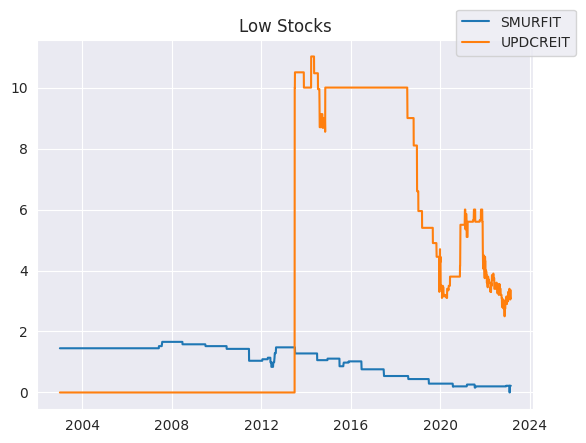

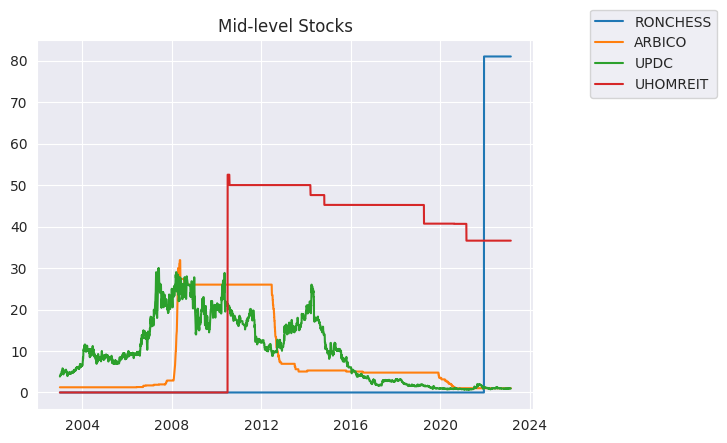

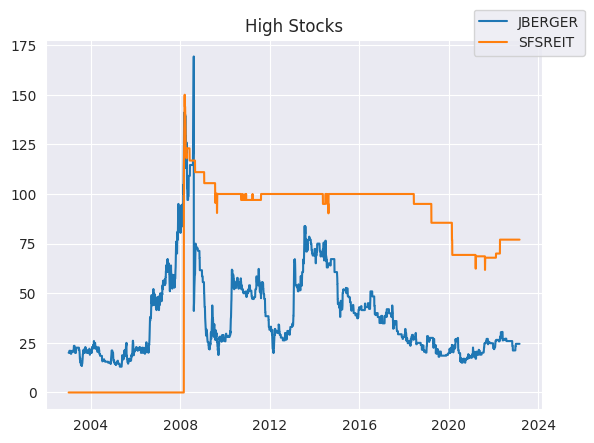

In [38]:
# constructionrs_tsdata[low_vol_cols].plot.line()
plt.plot(constructionrs_tsdata[low_vol_cols])
plt.legend(low_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("Low Stocks")
plt.show()

plt.plot(constructionrs_tsdata[mid_vol_cols])
plt.legend(mid_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("Mid-level Stocks")
plt.show()

plt.plot(constructionrs_tsdata[high_vol_cols])
plt.legend(high_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("High Stocks")
plt.show()

# MODEL BUILDING

## hyperparameter tuning

these parameters that can be tuned;

1. <b>`changepoint_prior_scale`</b>
2. <b>`seasonality_prior_scale`</b>
3. <b>`holidays_prior_scale`</b>
4. <b>`seasonality_mode`</b>
5. <b>`changepoint_range`</b>

In [39]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [40]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

seasonality_mode_options = ['additive', 'multiplicative']
# changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

<hr>

<b>`NOTE:`</b><br> in order to determine the effective accuracy of the model, in prophet cross-validation, I have to cut off the data at various times within the dates (not including the `2003`), over a large timeframe, so as to normalize. This gives rise to the importance for <b>`cross-validation`</b> 


## cross validation (prophet pipeline)

finding the <b>`"best"`</b> parameters by testing over various periods of time with those parameters (cross-validation)

In [32]:
start_time = time.time()

dicts = {}

for feature in constructionrs_tsdata.columns:
  
    stocksector_df = constructionrs_tsdata[feature].copy().reset_index()
    stocksector_df.columns = ["ds", "y"]

    stocksector_df[["y"]] = stocksector_df[["y"]].apply(pd.to_numeric)
    stocksector_df["ds"] = pd.to_datetime(stocksector_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # to generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(stocksector_df)  # fit model with given params
        df_cv = cross_validation(m, initial="365.25 days", period="365.25 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time))

21:27:39 - cmdstanpy - INFO - Chain [1] start processing
21:27:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:27:46 - cmdstanpy - INFO - Chain [1] start processing
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:09,  2.02it/s]21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:01<00:11,  1.52it/s]21:27:48 - cmdstanpy - INFO - Chain [1] start processing
21:27:48 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:02<00:15,  1.10it/s]21:27:49 - cmdstanpy - INFO - Chain [1] start processing
21:27:50 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:04<00:20,  1.27s/it]21:27:51 - cmdstanpy - INFO - Chain [1] start processing
21:27:51 - cmdstanpy - INFO - Chain [1] done processing
21:27:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse       mae      mape     mdape     smape  \
0 30 days  39.332431  6.271557  4.150187  0.731365  0.604964  0.542277   

   coverage  
0      0.68  


21:29:46 - cmdstanpy - INFO - Chain [1] start processing
21:29:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:29:53 - cmdstanpy - INFO - Chain [1] start processing
21:29:53 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:06,  2.85it/s]21:29:53 - cmdstanpy - INFO - Chain [1] start processing
21:29:53 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:00<00:06,  2.61it/s]21:29:54 - cmdstanpy - INFO - Chain [1] start processing
21:29:54 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:01<00:07,  2.18it/s]21:29:54 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:02<00:10,  1.60it/s]21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse      mae      mape     mdape     smape  \
0 30 days  40.248777  6.344192  4.24156  0.750967  0.653068  0.562433   

   coverage  
0     0.665  


21:31:31 - cmdstanpy - INFO - Chain [1] start processing
21:31:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:31:37 - cmdstanpy - INFO - Chain [1] start processing
21:31:37 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:10,  1.83it/s]21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:01<00:11,  1.62it/s]21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:01<00:11,  1.52it/s]21:31:39 - cmdstanpy - INFO - Chain [1] start processing
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:02<00:11,  1.34it/s]21:31:40 - cmdstanpy - INFO - Chain [1] start processing
21:31:40 - cmdstanpy - INFO - Chain [1] done processing
21:31:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse       mae    mape     mdape     smape  coverage
0 30 days  39.137275  6.255979  4.144125  0.7356  0.656892  0.563799  0.681667


21:33:20 - cmdstanpy - INFO - Chain [1] start processing
21:33:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:33:24 - cmdstanpy - INFO - Chain [1] start processing
21:33:25 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:07,  2.39it/s]21:33:25 - cmdstanpy - INFO - Chain [1] start processing
21:33:25 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:00<00:09,  1.97it/s]21:33:26 - cmdstanpy - INFO - Chain [1] start processing
21:33:26 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:01<00:11,  1.47it/s]21:33:27 - cmdstanpy - INFO - Chain [1] start processing
21:33:27 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:02<00:13,  1.19it/s]21:33:28 - cmdstanpy - INFO - Chain [1] start processing
21:33:28 - cmdstanpy - INFO - Chain [1] done processing
21:33:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse       mae      mape     mdape    smape  \
0 30 days  40.535278  6.366732  4.243273  0.749784  0.625029  0.56539   

   coverage  
0  0.658333  


21:35:07 - cmdstanpy - INFO - Chain [1] start processing
21:35:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:08,  2.22it/s]21:35:13 - cmdstanpy - INFO - Chain [1] start processing
21:35:13 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:00<00:08,  2.02it/s]21:35:13 - cmdstanpy - INFO - Chain [1] start processing
21:35:14 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:01<00:10,  1.57it/s]21:35:14 - cmdstanpy - INFO - Chain [1] start processing
21:35:14 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:02<00:11,  1.34it/s]21:35:15 - cmdstanpy - INFO - Chain [1] start processing
21:35:15 - cmdstanpy - INFO - Chain [1] done processing
21:35:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse       mae      mape     mdape     smape  \
0 30 days  39.911405  6.317547  4.195237  0.739326  0.652104  0.558775   

   coverage  
0  0.671667  


21:36:57 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

<b>`"df_p"`</b> gives the overall MAPE, but if you want to get more granular and calculate the daily differences using the mape metric, the code is below. This allows you to detect issues in predicting certain time periods, which are inherent issues in the data that you may or may not be able to fix. 

In [ ]:
#how to call params_dict for a feature

dicts

## feature engineering by `holidays`

In [ ]:
#adding holiday data

holiday = pd.DataFrame([])

nigeria_holidays = holidays.NG()  # this is a dict
# the below is the same, but takes a string:
nigeria_holidays = holidays.country_holidays('NG')  # this is a dict


for date_, name in sorted(holidays.NG(years=[2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "NG-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

## backtesting with tuned metrics
`latest month up-to-date mape`

In [ ]:
prediction_days = 30
forecast_start_date = max(constructionrs_tsdata.index) - timedelta(predictions_days)

<b>Note:</b> check a documentation here (reference to repo)!

In [ ]:
# PROPHET MODEL

forecasted_tsdata = []

for feature in constructionrs_tsdata.columns:

    # prophet formats
    df_constructionrs_copy = constructionrs_tsdata[feature].copy().reset_index()
    df_constructionrs_copy.columns = ['ds', 'y']
    df_constructionrs_copy[['y']] = df_constructionrs_copy[['y']].apply(pd.to_numeric)
    df_constructionrs_copy['ds'] = pd.to_datetime(df_constructionrs_copy['ds'])
    
    df_constructionrs_copy_train = df_constructionrs_copy[df_constructionrs_copy['ds'] < forecast_start_date]
    
    # search & get the right param_dict for this sector
    param_dict = dicts[feature]
    
    # model
    model = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                   seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                   holidays = holiday)
    
    model.fit(df_constructionrs_copy_train)
    
    future = model.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds'] >= forecast_start_date
    predicted_constructionrs_df = fcst_prophet_train[filter]['ds', 'yhat']
    predicted_constructionrs_df = predicted_constructionrs_df.merge(df_constructionrs_copy)

    print(feature, mape(predicted_constructionrs_df['y'], predicted_constructionrs_df['yhat']))

# FINAL FORECASTING

## forecast pipeline!!!

In [ ]:
days_of_predictiion = 672
start_date_of_forecast = max(constructionrs_tsdata.index)

In [ ]:
# using prophet model technique

forecasted_dataframe = []

for feature in constructionrs_tsdata_tsdata.columns: # plotting for first five: for feature in constructionrs_tsdata.columns[:5]:

    # formatting
    constructionrs_tsdata_copy = constructionrs_tsdata[feature].copy().reset_index()
    constructionrs_tsdata_copy.columns = ['ds', 'y']
    constructionrs_tsdata_copy[['y']] = constructionrs_tsdata_copy[['y']].apply(pd.to_numeric)
    constructionrs_tsdata_copy['ds'] = pd.to_datetime(constructionrs_tsdata_copy['ds'])

    constructionrs_tsdata_copy_train = constructionrs_tsdata_copy[constructionrs_tsdata_copy['ds'] < start_date_of_forecast]

    # search and get the rightparam_dicts for the sector
    param_dicts = dicts[feature]

    # model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                holidays = holiday)

    m.fit(constructionrs_copy_train)

    future_df = m.make_future_dataframe(periods = days_of_prediction)
    forecast_prophet_train = m.predict(future_df)
    
    fig1 = m.plot(forecast_prophet_train)
    fig2 = m.plot_components(forecast_prophet_train)

    forecasted_df = forecast_prophet_train[forecast_prophet_train['ds'] >= start_date_of_forecast]
    forecasted_dataframe.append(forecasted_df)

## forecasting visualization
2023 - March to December
2024 - January to December (leap year)

## Conclusions
<b>`...........................................................................................................`</b>